In [46]:
import tensorflow as tf
from tensorflow import keras

import math
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 16
})

SAVE_FIG = True

def save_fig(name, tight_layout = True):
    if SAVE_FIG:
        if not os.path.isdir("plots"):
            os.mkdir("plots")
        print(f"Saving figure {name} ...")
        if tight_layout:
            plt.tight_layout(pad=0.5)
        plt.savefig(f"plots/{name}.pdf", backend="pgf")

In [47]:
print(tf.__version__)

2.5.0


In [48]:
xs = tf.linspace(0, 14, 4000)
ys = tf.math.sin(xs)

Saving figure sine-curve ...


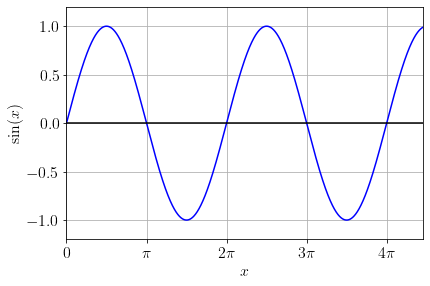

In [49]:
plt.plot(xs, ys, "b-")
plt.plot()
plt.grid()
plt.plot([-10, 20], [0, 0], "k-")
plt.axis([0, 14, -1.2, 1.2])
plt.xlabel("$x$")
plt.ylabel("$\sin(x)$")
plt.xticks(tf.range(0, 5 * math.pi, math.pi), ["0", "$\pi$", "$2\pi$", "$3\pi$", "$4\pi$"])
save_fig("sine-curve")
plt.show()

Saving figure sine-data ...


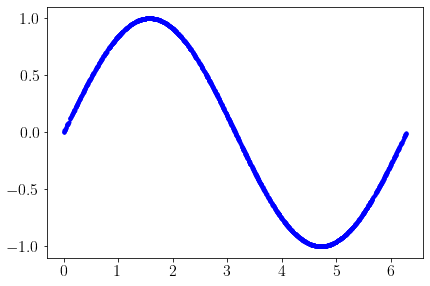

In [50]:
SAMPLES = 2000

tf.random.set_seed(42)

x = tf.random.uniform((SAMPLES, 1), minval=0, maxval=2*math.pi)

tf.random.shuffle(x)

y = tf.math.sin(x)

plt.plot(x, y, "b.")
save_fig("sine-data")
plt.show()

Saving figure sine-data-noise ...


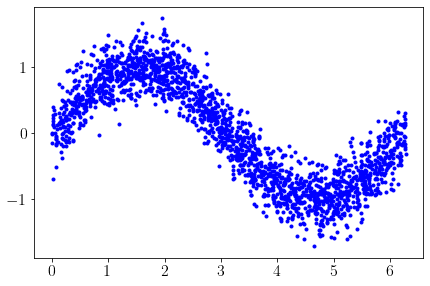

In [51]:
y += 0.25 * tf.random.normal(y.shape)
plt.plot(x, y, "b.")
save_fig("sine-data-noise")
plt.show()

Saving figure over_underfitting ...


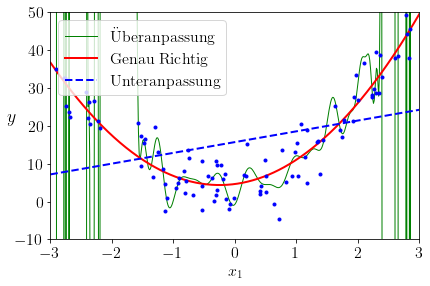

In [52]:
def plot_over_underfitting():
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures

    x = tf.random.uniform((100, 1), minval=-3, maxval=3)
    y = 5 + 2*x + 4*(x**2) + 5 * tf.random.normal((100, 1))

    x_new = tf.linspace([-3], [3], 500)

    features = (
        ("g-", 1, 300, "Überanpassung"),
        ("r-", 2, 2, "Genau Richtig"),
        ("b--", 2, 1, "Unteranpassung")
    )
    
    for style, width, degree, label in features:
        polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
        std_scaler = StandardScaler()
        lin_reg = LinearRegression()
        polynomial_regression = Pipeline([
                ("poly_features", polybig_features),
                ("std_scaler", std_scaler),
                ("lin_reg", lin_reg),
            ])
        polynomial_regression.fit(x, y)
        y_new = polynomial_regression.predict(x_new)
        plt.plot(x_new, y_new, style, label=label, linewidth=width)

    plt.plot(x, y, "b.", linewidth=3)
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.axis([-3, 3, -10, 50])
    save_fig("over_underfitting")
    plt.show()

plot_over_underfitting()

In [53]:
TRAIN_SIZE = int(0.5 * SAMPLES)
TEST_SIZE = int(0.2 * SAMPLES)
VAL_SIZE = SAMPLES - TRAIN_SIZE - TEST_SIZE

x_train, x_test, x_val = tf.split(x, [TRAIN_SIZE, TEST_SIZE, VAL_SIZE])
y_train, y_test, y_val = tf.split(y, [TRAIN_SIZE, TEST_SIZE, VAL_SIZE])

assert tf.size(x_train) + tf.size(x_test) + tf.size(x_val) == SAMPLES

Saving figure sine-data-noise-split ...


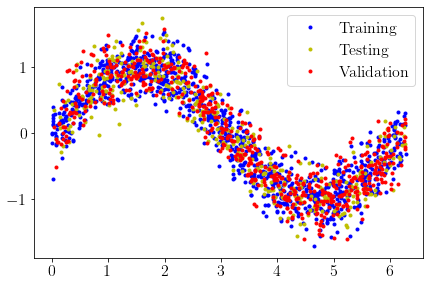

In [54]:
plt.plot(x_train, y_train, "b.", label="Training")
plt.plot(x_test, y_test, "y.", label="Testing")
plt.plot(x_val, y_val, "r.", label="Validation")
plt.legend()
save_fig("sine-data-noise-split")
plt.show()

Saving figure activation-functions ...


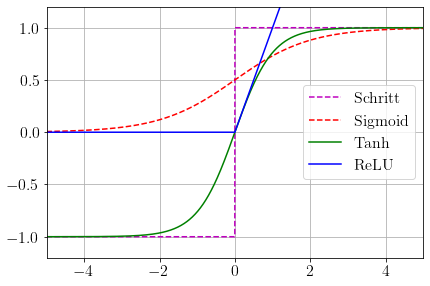

In [55]:
def plot_activation_functions():
    z = tf.linspace(-6, 6, 3000)

    def relu(z):
        x = tf.constant(0, dtype=z.dtype),
        return tf.maximum(x, z)
    
    def sigmoid(z):
        return 1 / (1 + tf.math.exp(-z))

    def tanh(z):
        return 2 * sigmoid(2 * z) - 1

    def step(z):
        return tf.map_fn(lambda t: -1 if t < 0 else 1, z)

    plt.plot(z, step(z), "m--", label="Schritt")
    plt.plot(z, sigmoid(z), "r--", label="Sigmoid")
    plt.plot(z, tanh(z), "g-", label="Tanh")
    plt.plot(z, relu(z), "b-", label="ReLU")
    plt.grid()
    plt.axis([-5, 5, -1.2, 1.2])
    plt.legend(loc="center right")
    save_fig("activation-functions")
    plt.show()

plot_activation_functions()

In [56]:
input_layer = keras.layers.Input(shape=[1])
hidden1 = keras.layers.Dense(16, activation="relu")(input_layer)
output_layer = keras.layers.Dense(1, name="output")(hidden1)

model_1 = keras.Model(inputs=input_layer, outputs=output_layer)

In [57]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                32        
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_1.layers

In [59]:
hidden1 = model_1.layers[1]
print(hidden1.name)
print(model_1.get_layer("dense") is hidden1)

dense_4


ValueError: No such layer: dense.

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

In [ ]:
weights.shape

In [ ]:
biases

In [ ]:
biases.shape

In [ ]:
sgd = tf.keras.optimizers.SGD()
model_1.compile(optimizer=sgd, loss="mse", metrics=["mae"])

In [ ]:
EPOCHS = 300
BATCH_SIZE = 16
history_1 = model_1.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val))

In [ ]:
x_train.shape

In [ ]:
hidden1 = model_1.get_layer("dense")
weights, biases = hidden1.get_weights()

In [ ]:
weights

In [ ]:
biases

In [ ]:
history_1.history.keys()

In [ ]:
mse_1 = history_1.history["loss"]
val_mse_1 = history_1.history["val_loss"]
mae_1 = history_1.history["mae"]
val_mae_1 = history_1.history["val_mae"]
assert len(mse_1) == len(val_mse_1) == EPOCHS
assert len(mae_1) == len(val_mae_1) == EPOCHS

In [ ]:
from matplotlib.ticker import StrMethodFormatter

epochs = tf.range(0.0, EPOCHS)

plt.subplot(211)
plt.plot(epochs, mse_1, "b-", label="Training")
plt.plot(epochs, val_mse_1, "g-", label="Validation")
plt.grid()
plt.ylabel("$MSE$", labelpad=12)
plt.legend(loc="upper right")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
plt.axis([0, EPOCHS, 0.18, 0.4])

plt.subplot(212)
plt.plot(epochs, mae_1, "b-", label="Training")
plt.plot(epochs, val_mae_1, "g-", label="Validation")
plt.grid()
plt.xlabel("Epochen")
plt.ylabel("$MAE$", labelpad=12)
plt.axis([0, EPOCHS, 0.35, 0.45])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
save_fig("1-metrics")
plt.show()

In [ ]:
model_1.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

In [ ]:
predictions_1 = model_1.predict(x_test)

plt.plot(x_test, y_test, "b.", label="Testing")
plt.plot(xs, ys, "r-")
plt.plot(x_test, predictions_1, "y.", label="Prognose")
plt.xlim([0, 2*math.pi])
plt.legend()
save_fig(f"1-predictions")
plt.show()

In [ ]:
input_layer = keras.Input(shape=[1])
hidden1 = keras.layers.Dense(8, activation="relu")(input_layer)
hidden2 = keras.layers.Dense(16, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(32, activation="relu")(hidden2)
output_layer = keras.layers.Dense(1, name="output")(hidden3)

model_2 = keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model_2.summary()

In [ ]:
sgd = tf.keras.optimizers.SGD()
model_2.compile(optimizer=sgd, loss="mse", metrics=["mae"])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=EPOCHS,
    monitor="loss",
    verbose=1,
    restore_best_weights=True)

history_2 = model_2.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val))

In [ ]:
mse_2 = history_2.history["loss"]
val_mse_2 = history_2.history["val_loss"]
mae_2 = history_2.history["mae"]
val_mae_2 = history_2.history["val_mae"]
assert len(mse_2) == len(val_mse_2) == EPOCHS
assert len(mae_2) == len(val_mae_2) == EPOCHS

In [ ]:
epochs = tf.range(0.0, EPOCHS)

plt.plot(epochs, mse_2, "b-", label="Training")
plt.plot(epochs, val_mse_2, "g-", label="Validation")
plt.grid()
plt.xlabel("Epochen")
plt.ylabel("$MSE$")
plt.legend(loc="upper center")
plt.axis([0, EPOCHS, 0.05, 0.25])
save_fig("2-mse")
plt.show()

plt.plot(epochs, mae_2, "b-", label="Training")
plt.plot(epochs, val_mae_2, "g-", label="Validation")
plt.grid()
plt.xlabel("Epochen")
plt.ylabel("$MAE$")
plt.legend(loc="upper center")
plt.axis([0, EPOCHS, 0.18, 0.4])
save_fig("2-mae")
plt.show()

In [ ]:
model_2.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

In [ ]:
predictions_2 = model_2.predict(x_test)
plt.plot(x_test, y_test, "b.", label="Testdaten")
plt.plot(xs, ys, "r-")
plt.plot(x_test, predictions_2, "y.", label="Prognose")
plt.xlim([0, 2*math.pi])
plt.legend()
save_fig("2-predictions")
plt.show()

In [ ]:
def save_model(model, model_name: str):
    with open(model_name, "wb") as f:
        f.write(model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

save_model(tflite_model, "sine_model.tflite")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset():
    for value in x_test:
        yield [value]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model = converter.convert()

save_model(tflite_model, "sine_model_quant.tflite")

In [ ]:
sine_model = tf.lite.Interpreter("sine_model.tflite")
sine_model_quant = tf.lite.Interpreter("sine_model_quant.tflite")

sine_model.allocate_tensors()
sine_model_quant.allocate_tensors()

input_details = sine_model.get_input_details()[0]
output_details = sine_model.get_output_details()[0]

input_details_quant = sine_model_quant.get_input_details()[0]
output_details_quant = sine_model_quant.get_output_details()[0]

input_scale, input_zero_point = input_details_quant["quantization"]

input_index = input_details["index"]
output_index = output_details["index"]

input_index_quant = input_details_quant["index"]
output_index_quant = output_details_quant["index"]

sine_model_predictions = []
sine_model_quant_predictions = []

for value in x_test:
    tensor_float32 = tf.convert_to_tensor([value], dtype=tf.float32)
    tensor_int8 = tf.convert_to_tensor([value / input_scale + input_zero_point], dtype=tf.int8)

    sine_model.set_tensor(input_index, tensor_float32)
    sine_model_quant.set_tensor(input_index_quant, tensor_int8)

    sine_model.invoke()
    sine_model_quant.invoke()

    sine_model_predictions.append(
        sine_model.get_tensor(output_index)[0,0]
    )
    sine_model_quant_predictions.append(
        sine_model_quant.get_tensor(output_index_quant)[0,0] / abs(input_zero_point)
    )

In [ ]:
plt.plot(x_test, y_test, "b.", label="Testdaten")
plt.plot(x_test, predictions_2, "ro", label="Ursprüngliche Prognose")
plt.plot(x_test, sine_model_predictions, "yx", label="Lite Prognose")
plt.plot(x_test, sine_model_quant_predictions, "g+", label="Lite Quantisierte Prognose")
plt.legend()
save_fig("model-comparison")
plt.show()

In [ ]:
import os
sine_size = os.path.getsize("sine_model.tflite")
print(f"Sine model size: {sine_size}")
sine_quant_size = os.path.getsize("sine_model_quant.tflite")
print(f"Sine quant model size: {sine_quant_size}")

In [ ]:
import platform

EDGETUP_LIB = {
    "Linux": "libedgetpu.so.1",
    "Darwin": "libedgetpu.1.dylib",
    "Windows": "edgetpu.dll",
}[platform.system()]

delegates = [tf.lite.experimental.load_delegate(EDGETUP_LIB)]
sine_model_tpu = tf.lite.Interpreter(
    "sine_model_quant_edgetpu.tflite",
    experimental_delegates=delegates
)

sine_model_tpu.allocate_tensors()

input_details_tpu = sine_model_tpu.get_input_details()[0]
output_details_tpu = sine_model_tpu.get_output_details()[0]

input_index_tpu = input_details_tpu["index"]
output_index_tpu = output_details_tpu["index"]

In [ ]:
import time

values = tf.random.uniform((2000, 1, 1), minval=1, maxval=5)
values = values / input_scale + input_zero_point
values = tf.cast(values, dtype=tf.int8)

start = time.perf_counter()
for value in values:
    sine_model_tpu.set_tensor(input_index_tpu, value)
    sine_model_tpu.invoke()
inference_time = (time.perf_counter() - start) * 1000

print(inference_time)

In [ ]:
values = tf.random.uniform((2000, 1, 1), minval=1, maxval=5)

start = time.perf_counter()
for value in values:
    sine_model.set_tensor(input_index, value)
    sine_model.invoke()
inference_time = (time.perf_counter() - start) * 1000

print(inference_time)